Import libraries and data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Libraries
import pandas as pd
import numpy as np

In [4]:
#Data
df = pd.read_csv("/content/drive/MyDrive/Datasc/Forecasting Models and Time Series for Business in Python/Daily Bike Sharing.csv", 
                 index_col = "dteday", 
                 parse_dates = True)
df.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2011-01-02,2,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2011-01-03,3,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
2011-01-04,4,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
2011-01-05,5,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [5]:
#Select variables
dataset = df.loc[:,["cnt", "holiday", "workingday", "weathersit", "temp", "atemp",
                   "hum", "windspeed"]]
dataset.head(1)

,cnt,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


Data transformation

In [6]:
#Renaming variable
dataset = dataset.rename(columns = {"cnt" : "y"})
dataset.head(1)

,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


In [7]:
#index
dataset.index

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2012-12-22', '2012-12-23', '2012-12-24', '2012-12-25',
               '2012-12-26', '2012-12-27', '2012-12-28', '2012-12-29',
               '2012-12-30', '2012-12-31'],
              dtype='datetime64[ns]', name='dteday', length=731, freq=None)

In [8]:
#freq = None - significa que para Python los intervalos no nos frecuentes con el tiempo, esto no es cierto así que necesitamos corregir el parámetro freq
dataset = dataset.asfreq("D")
dataset.index

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2012-12-22', '2012-12-23', '2012-12-24', '2012-12-25',
               '2012-12-26', '2012-12-27', '2012-12-28', '2012-12-29',
               '2012-12-30', '2012-12-31'],
              dtype='datetime64[ns]', name='dteday', length=731, freq='D')

Visualization

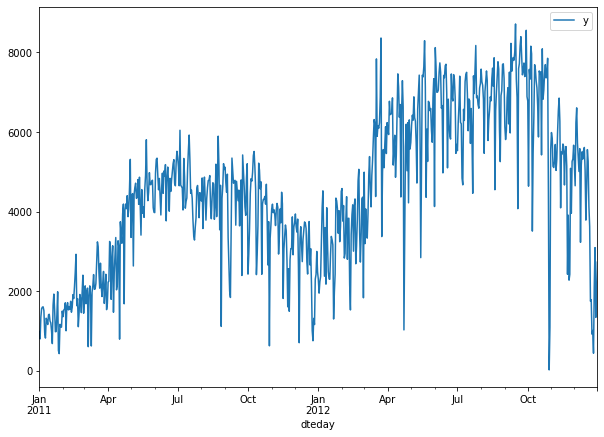

In [9]:
#viz
dataset["y"].plot(figsize = (10, 7), legend = True)

Training and test Set

In [10]:
#Training and test set ( test van a ser los últimos 31 días del dataset)
test_days = 31
training_set = dataset.iloc[:-test_days, :] #todo menos los últimos 31 días
test_set = dataset.iloc[-test_days:, :]

Forecasting model

In [11]:
#Libraries
import tensorflow_probability as tfp

In [12]:
#Isolate the regressors
exog = np.asmatrix(dataset.iloc[:,1:].astype(np.float64)) #Para el modelo los datos tienen que estar en formato matriz y los números tienen que ser float
exog

matrix([[0.      , 0.      , 2.      , ..., 0.363625, 0.805833, 0.160446],
        [0.      , 0.      , 2.      , ..., 0.353739, 0.696087, 0.248539],
        [0.      , 1.      , 1.      , ..., 0.189405, 0.437273, 0.248309],
        ...,
        [0.      , 0.      , 2.      , ..., 0.2424  , 0.752917, 0.124383],
        [0.      , 0.      , 1.      , ..., 0.2317  , 0.483333, 0.350754],
        [0.      , 1.      , 2.      , ..., 0.223487, 0.5775  , 0.154846]])

In [13]:
#Linear regression
regressors = tfp.sts.LinearRegression(design_matrix= exog, 
                                      name = "regressors")

In [14]:
#Seasonality I
#isolating dependent variables
y = training_set["y"].astype(np.float64)
y

dteday
2011-01-01     985.0
2011-01-02     801.0
2011-01-03    1349.0
2011-01-04    1562.0
2011-01-05    1600.0
               ...  
2012-11-26    5087.0
2012-11-27    3959.0
2012-11-28    5260.0
2012-11-29    5323.0
2012-11-30    5668.0
Freq: D, Name: y, Length: 700, dtype: float64

In [15]:
#Seasonality II
#Weekday seasonality
weekday_effect = tfp.sts.Seasonal(num_seasons= 7,
                                  num_steps_per_season = 1,
                                  observed_time_series = y,
                                  name = "weekday_effects")
#number of days per month
num_day_per_month = np.array([[31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31], #2011
                              [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]]) #2012

#Monthly seasonality
monthly_effect = tfp.sts.Seasonal(num_seasons= 12,
                                  num_steps_per_season = num_day_per_month,
                                  observed_time_series = y,
                                  name = "monthly_effects")         

In [16]:
### Autoregressive and trend componenets
#trend
trend = tfp.sts.LocalLinearTrend(observed_time_series= y,
                                 name = "trend")
#Autoregressive
autoregressive = tfp.sts.Autoregressive(order = 1,
                                        observed_time_series = y,
                                        name = "Autoregressive")

In [17]:
#Forecasting model
model = tfp.sts.Sum([regressors,
                     weekday_effect,
                     monthly_effect,
                     autoregressive,
                     trend],
                    observed_time_series= y)

In [18]:
#Fit with HMC (Hamiltonian Monte-Carlo)
samples, kernel_results = tfp.sts.fit_with_hmc (model = model,
                                                observed_time_series = y,
                                                num_results = 100,
                                                num_warmup_steps= 50,
                                                num_leapfrog_steps = 15,
                                                num_variational_steps = 150,
                                                seed = 1502)

/usr/local/lib/python3.8/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [19]:
#Forecast
forecast = tfp.sts.forecast (model = model,
                             observed_time_series = y,
                             parameter_samples = samples,
                             num_steps_forecast = len(test_set))

In [20]:
#Predictions HMC
predictions_tfp = pd.Series(forecast.mean()[:,0], name = "TFP")
predictions_tfp.index = test_set.index
#predictions_tfp[:2]

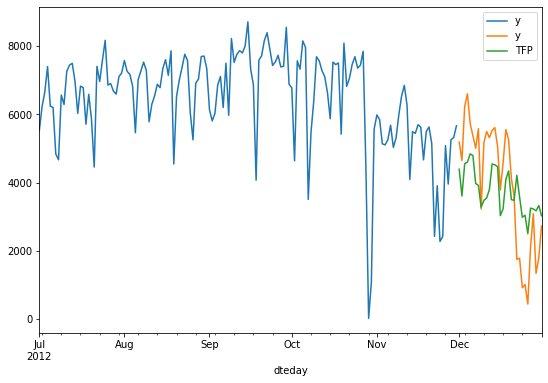

In [21]:
#Visualization
training_set["y"]["2012-07-01":].plot(figsize = (9, 6), legend = True)
test_set["y"].plot(legend = True)
predictions_tfp.plot(legend = True)

Model assessment

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(test_set["y"], predictions_tfp),0))
print(round(np.sqrt(mean_squared_error(test_set["y"], predictions_tfp)),0))

1231.0
1389.0


In [24]:
#MAPE function
def MAPE (y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/ y_true))*100
MAPE(test_set["y"], predictions_tfp)

59.895182203443454

Export forecast

In [ ]:
#predictions_X.to_csv("3_predictions_X.csv", index = True)